We represent an image of n pixexls by,  $ I = f(Ur) + n$. I is the image, U is a matrix, r is a set of causes, and n is a stochastic process representing devations from the image and the consequences of causes. The colums of U are a basis of the relationship between causes and the images. So we have the the image is a generated by a linear superposition of causes followed by a nonlinearity. 

Converting this to a neural network, the coeficients $r_j$ are the activities of firing rates of neurons, and the matrix columns $U_j$ are the synaptic weights. The function f(x) is then the neuronal activation function. Then we have that the $r_j$s are the networks representation of the image, interpreted using the internal model defined by the columns of U.

We add heirarchy to this model by assuming that the causes r can be represented by a set of higher level causes $r^h$. So we get $ r = r^{td}+n^{td}$, and the top down prediction of r is $r^{td}=f(U^hr^h)$. 

Assume that the noise terms are Gaussian with zero mean and variances $\sigma^2$ and $\sigma_{td}^2$. Then we have the following activation function:

$$E_1 = \frac{1}{\sigma^2}(I-f(Ur))^T(I-f(Ur))+\frac{1}{\sigma_{td}^2}(r-r^{td})^T(r-r^{td})$$

which is the negative log of the probability of the data given the parameters. It is the sume of squared prediction errors for level 1 and level 2, with each term being weighted by inverse variance.

$$\mathcal{L}= \frac{1}{\sigma^2}|\textbf{I}-f(\textbf{U}r)|^2 +  \frac{1}{\sigma^2}|r-f(\textbf{U}^hr^h)|^2   +g(\textbf{u})+h(r)+g(\textbf{u})+h(r)$$

In [3]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# We are going to make a predictive coding model, like from Rao and Ballard 1999
# set up the model


num_pixels = 128 # number of pixels in the image
num_causes = 12 # number of causes
num_higher_causes = 8 # number of higher level causes

# The input image
I = torch.rand(size=(num_pixels,1), requires_grad=True) 

# The parameters of the model
sigma = 0.1
sigma_h = 0.2

# The lower level causes
U = torch.rand(size=(num_pixels, num_causes), requires_grad=True) # the causes basis
r = torch.rand(size=(num_causes, 1), requires_grad=True) # representation of the cause of an image

# The higher level causes
U_h = torch.rand(size=(num_causes, num_higher_causes), requires_grad=True)
r_h = torch.rand(size=(num_higher_causes,1), requires_grad=True)

precision = 1/(sigma**2)
precision_h = 1/(sigma_h**2)
f = torch.tanh

# The model
prediction0 = f(torch.einsum('ij,jk->ik',U,r))
prediction_error0 = I - prediction0

prediction1 = f(torch.einsum('ij,jk->ik',U_h,r_h))
prediction_error1 = r - prediction1

log_likelihood = precision*torch.norm(prediction_error0)**2 + \
                precision_h*torch.norm(prediction_error1)**2 

log_likelihood.backward()

dLdr = r.grad # the gradient of the log likelihood with respect to the representation
dLdU = U.grad # the gradient of the log likelihood with respect to the basis


In [4]:
# ok now we want to load images
import torchvision
import torchvision.transforms as transforms

# transform the images so that they are spatially downsampled by a factor of 2
transform = transforms.Compose(
    [transforms.Resize((32,32)),
        transforms.ToTensor()])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                            shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                        download=False, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2) 

classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')




In [10]:
images, labels = next(iter(trainloader))

# Assume that you have a batch of images with shape (batch_size, channels, height, width)
batch_size, channels, height, width = images.shape

# Define the patch size and stride
patch_size = (16, 16)
stride = (8, 8)

# Extract patches from the images using the patch size and stride
patches = images.unfold(2, patch_size[0], stride[0]).unfold(3, patch_size[1], stride[1])

# Reshape the patches tensor to have shape (batch_size, patch, channel, height, width)
patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous().view(batch_size, -1, channels, patch_size[0], patch_size[1])




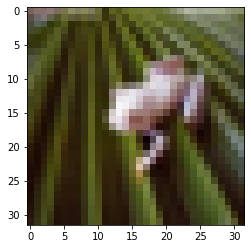

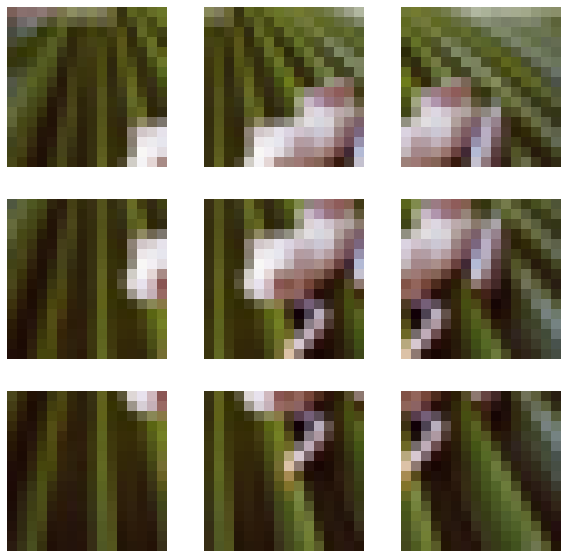

In [11]:
# look at the first image
plt.imshow(np.transpose(images[0], (1, 2, 0)))

# look at the patches corresponding to the first image
# make sure the grid is the right shape, i.e. square
num_patches = int(np.sqrt(patches[0].shape[0]))
# make the figure big
plt.figure(figsize=(10,10))
# make the grid
for i in range(num_patches**2):
    plt.subplot(num_patches,num_patches,i+1)
    plt.imshow(np.transpose(patches[0,i], (1, 2, 0)))
    plt.axis('off')

In [95]:
# images is of dimension (batch_size, channels, height, width)
# patches is of dimension (batch_size, num_patches, channels, patch_size[0], patch_size[1])

# now we want to make a predictive coding model, like from Rao and Ballard 1999
# set up the model

# we will flatten the patches into vectors of dimension (batch_size, num_patches, channels*patch_size[0]*patch_size[1])
patches = patches.view(batch_size, -1, channels*patch_size[0]*patch_size[1])

# define a torch module for a single patch
class PredictiveCodingLevel(nn.Module):
    def __init__(self, num_pixels, num_causes, k1, k2, sigma, alpha, lam):
        super(PredictiveCodingLevel, self).__init__()
        self.num_pixels = num_pixels # number of pixels in the image
        self.num_causes = num_causes # number of causes
        self.k1 = k1 # learning rate for r
        self.k2 = k2 # learning rate for U
        self.sigma = sigma # noise level
        self.alpha = alpha # weight on the r prior
        self.lam = lam # weight on U prior
        self.U = nn.Parameter(torch.rand(size=(num_pixels, num_causes)))
        # do xavier initialization on U
        nn.init.xavier_uniform_(self.U)
        self.r = nn.Parameter(torch.zeros(size=(num_causes, 1)))
        self.f = torch.tanh
        self.precision = 1/(sigma**2)
        self.U_prior = torch.norm
        self.r_prior = torch.norm

        # these are for bookkeeping
        self.prediction = None
        self.prediction_error = None
        self.prediction_loss = None
        self.U_prior_loss = None
        self.r_prior_loss = None
        self.total_loss = None

    def forward(self, x):
        # x is the input "image" which is flattened to a vector of size (1, num_pixels)
        prediction = self.f(torch.einsum('ij,jk->ik',self.U,self.r))
        prediction_error = x - prediction
        prediction_loss = self.precision*torch.norm(prediction_error)**2
        U_prior_loss = self.lam*self.U_prior(self.U)
        r_prior_loss = self.alpha*self.r_prior(self.r)

        # update internal values
        self.prediction = prediction
        self.prediction_error = prediction_error
        self.prediction_loss = prediction_loss
        self.U_prior_loss = U_prior_loss
        self.r_prior_loss = r_prior_loss
        self.total_loss = prediction_loss + U_prior_loss + r_prior_loss

        return self.r





In [102]:
images, labels = next(iter(trainloader))

# Assume that you have a batch of images with shape (batch_size, channels, height, width)
batch_size, channels, height, width = images.shape

# Define the patch size and stride
patch_size = (16, 16)
stride = (8, 8)

# Extract patches from the images using the patch size and stride, shape is 
patches = images.unfold(2, patch_size[0], stride[0]).unfold(3, patch_size[1], stride[1])

# Reshape the patches tensor to have shape (batch_size, patch, channel, height, width)
patches = patches.permute(0, 2, 3, 1, 4, 5).contiguous().view(batch_size, -1, channels, patch_size[0], patch_size[1])

# flatten the patches into shape (batch_size, num_patches, channels*patch_size[0]*patch_size[1])
patches = patches.view(batch_size, -1, channels*patch_size[0]*patch_size[1])
print(patches.shape)

# now take all patches and make them into a single vector, final shape is (batch_size, num_patches*channels*patch_size[0]*patch_size[1])
patches = patches.view(batch_size, -1)
print(patches.shape)

batch_size, num_pixels = patches.shape

# define the model, it will be two PredictiveCodingLevel modules
# the first will have num_causes = 100, and the second will have num_causes = 200
model = nn.Sequential(PredictiveCodingLevel(num_pixels, 50, k1=0.5, k2=.1, sigma=np.sqrt(1), alpha=1, lam=0.02), 
                            PredictiveCodingLevel(50, 100, k1=0.5, k2=.1, sigma=np.sqrt(10), alpha=0.05, lam=0.02))

# for each image in the batch, run the model for 100 timesteps
for i in range(batch_size):
    for t in range(1000):
        output = model(patches[i])


        #  define loss as the sum of total loss from all layers of the model
        loss = sum([layer.total_loss for layer in model])

        #backpropagate the loss
        loss.backward()

        # compute the gradients with respect to U and r for each layer
        U_gradients = [layer.U.grad for layer in model]
        r_gradients = [layer.r.grad for layer in model]

        # update the parameters with the gradients
        #  if iterations < 500 only do this for layer 1
        # else do for both

        model[0].U.data += -model[0].k2/2*model[0].U.grad
        model[0].r.data += -model[0].k1/2*model[0].r.grad
        model[1].U.data += -model[1].k2/2*model[1].U.grad
        model[1].r.data += -model[1].k1/2*model[1].r.grad

        # zero out the gradients for the entire model
        model.zero_grad()
        
        # every 10 iterations, print out the loss
        # but also print out the iteration, the batch number, and the abs max of U and r
        # and keep it very neat
        if t % 10 == 0:
            print("Iteration: {:4d} | Batch: {:4d} | Loss: {:10.5f} | U max: {:10.5f} | r max: {:10.5f}".format(t, i, loss.item(), model[0].U.max().item(), model[0].r.max().item()))

        # every 40 iterations, divide k2 by 1.015
        if t % 40 == 39:
            for layer in model:
                layer.k2 /= 1.015








torch.Size([4, 9, 768])
torch.Size([4, 6912])
Iteration:    0 | Batch:    0 | Loss: 13141662.00000 | U max:    0.02935 | r max: 4659.74316
Iteration:   10 | Batch:    0 | Loss: 65442884.00000 | U max: 2364378.25000 | r max: 2899.07666
Iteration:   20 | Batch:    0 | Loss: 60603448.00000 | U max: 2364378.25000 | r max: 1735.47595
Iteration:   30 | Batch:    0 | Loss: 58928376.00000 | U max: 2364378.25000 | r max: 1038.78528
Iteration:   40 | Batch:    0 | Loss: 58521048.00000 | U max: 2364378.25000 | r max:  621.65063


KeyboardInterrupt: 

In [92]:
losses.shape

torch.Size([4, 2])

In [76]:
# print max U and r values
for layer in model:
    print('U max: ', torch.max(layer.U.data))
    print('r max: ', torch.max(layer.r.data))

U max:  tensor(2.6712e+08)
r max:  tensor(1.7499e+10)
U max:  tensor(27689968.)
r max:  tensor(657.3454)


In [68]:
#  define loss as the sum of total loss from all layers of the model
loss = sum([layer.total_loss for layer in model])

#backpropagate the loss
loss.backward()

# compute the gradients with respect to U and r for each layer
U_gradients = [layer.U.grad for layer in model]
r_gradients = [layer.r.grad for layer in model]

# print the min and max gradiets
print('U gradients')
print('min: ', min([torch.min(U) for U in U_gradients]))
print('max: ', max([torch.max(U) for U in U_gradients]))

# update the parameters with the gradients
for i, layer in enumerate(model):
    layer.U.data -= .001*layer.U.grad
    layer.r.data -= .00001*layer.r.grad

# for each layer in the model, print out the 3 losses and the mean abs prediction error
# also print the precision
for i, layer in enumerate(model):
    print('layer %d' % i)
    print('prediction loss: ', layer.prediction_loss)
    print('U prior loss: ', layer.U_prior_loss)
    print('r prior loss: ', layer.r_prior_loss)
    print('mean abs prediction error: ', torch.mean(torch.abs(layer.prediction_error)))
    print('precision: ', layer.precision)




U gradients
min:  tensor(-6.0823e+10)
max:  tensor(6.0823e+10)
layer 0
prediction loss:  tensor(1.4597e+09, grad_fn=<MulBackward0>)
U prior loss:  tensor(14.0404, grad_fn=<CopyBackwards>)
r prior loss:  tensor(0., grad_fn=<CopyBackwards>)
mean abs prediction error:  tensor(0.5301, grad_fn=<MeanBackward0>)
precision:  99.99999999999999
layer 1
prediction loss:  tensor(2.1307e+22, grad_fn=<MulBackward0>)
U prior loss:  tensor(11.5392, grad_fn=<CopyBackwards>)
r prior loss:  tensor(0., grad_fn=<CopyBackwards>)
mean abs prediction error:  tensor(1.4597e+09, grad_fn=<MeanBackward0>)
precision:  99.99999999999999


In [58]:
# wprint out the min and max of the inputs
print('min input: ', patches.min())
print('max input: ', patches.max())


min input:  tensor(0.0588)
max input:  tensor(1.)
